In [1]:
from report import *
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

total: 176474
residents: 160748
vacant: 15726
edges: 132489


In [3]:
"""
load model/report
"""
import os
path='model/'
files = [f[:-4] for f in os.listdir(path) if f.endswith('.mps')]
files.sort()

model_house_df = pd.read_csv('modelsTable',index_col=0)
model_house_df = pd.DataFrame(np.array(model_house_df),
                              columns=['model','iter','Cost','Num_of_houses','ObjVal','Time','budg'] + 
                              list(gdf.ID))

In [52]:
def read_geo_file(file_name = 'OriginalDataBaseFile/RealPropertiesExtraClean.csv'):
    """ 
    read file from csv and return geodataframe
    """
    df = pd.read_csv(file_name) 
    df.rename(columns={"Parcel":"geometry"},inplace=True)
    df.geometry = df.geometry.apply(lambda var: MultiPolygon([wkt.loads(var)])) # string to multipolygon

    gdf = gpd.GeoDataFrame(df)
    gdf["Block"] = gdf.BlockLot.apply(lambda num: num[:4])
    gdf.crs = {'init' :'epsg:4326'}
    
    gdf['x'] = gdf.geometry.centroid.x # Longitude
    gdf['xradians'] = gdf.x.apply(radians) # x coords to radians
    gdf['y'] = gdf.geometry.centroid.y # Latitude
    gdf['yradians'] = gdf.y.apply(radians) # y coords to radians
    gdf['yx'] = zip(gdf.y,gdf.x) # (lat, lon)
    
    # for optimization computation
    gdf['xyradians'] = zip(gdf.xradians,gdf.yradians)
    gdf['xyrID'] = zip(gdf.xyradians,gdf.ID)
    
    return gdf

In [53]:
totalgdf = read_geo_file()

In [56]:
check = set(gdf.ID)
background = totalgdf[totalgdf.ID.apply(lambda var: var not in check)]

In [38]:
def real_dis_affect(col,col2,power = 1, upper = 500):
    lon1, lat1 = col
    lon2, lat2 = col2
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dis = R * c*1000 
    #return dis if dis < upper else 0

    return 1.0/(dis**power) if dis < upper else 0

In [78]:
def Area_plot(file_ ,iter_, budg , ax= None,radius = None, power = None):
    #print file_,iter_
    demolished = model_house_df[(model_house_df.model == file_) & (model_house_df.iter == iter_) & 
                                (model_house_df.budg == budg)].iloc[0,7:]

    tempgdf = gdf.copy()
    tempgdf["demolished"] = tempgdf.ID.apply(lambda var: demolished[var])

    if not radius:
        radius = int(file_.split("-")[1][1:])
        power = int(file_.split("-")[2][1:])
    
    
    tempogdf = ogdf.copy()
    tempogdf["improve"] = np.zeros(len(tempogdf))
    tempogdf.set_index('ID',inplace = True)
    
    # try get the object value again.......QQ
    count = 0
    for id_ in tempgdf[tempgdf.demolished == 1].ID:
        
        index = tempogdf[((tempogdf.xradians <= vgdf[vgdf.ID == id_].xradians.iloc[0] + 0.00012) & 
        (tempogdf.xradians >= vgdf[vgdf.ID == id_].xradians.iloc[0] - 0.00012) &
        (tempogdf.yradians <= vgdf[vgdf.ID == id_].yradians.iloc[0] + 0.0001) & 
        (tempogdf.yradians >= vgdf[vgdf.ID == id_].yradians.iloc[0] - 0.0001) )].index

        
        curpoint = vgdf[vgdf.ID == id_].xyradians.iloc[0]
            
        curval = list(tempogdf.loc[index,"xyrID"].apply(
            lambda var: real_dis_affect(var[0],curpoint,
                                        power = power,upper = radius)))
        tempogdf.loc[index,"improve"] += curval
        
        if sum(curval) == 0:
            print "value error"
        
        count += 1
        
    # color map:
    ##   hot_r, cubehelix, gnuplot2, inferno
    vmin_ = 0
    colormap = 'inferno'
    vacantcolor = "aliceblue"
    vmax_ = tempogdf.improve.max() + 15
    selfax = False
    if ax == None:
        fig = plt.figure(figsize=(16,16), dpi=150)
        ax = fig.add_subplot(111)
        ax2 = fig.add_axes([0.07,0.06,0.25,0.29])
        ax3 = fig.add_axes([0.35,0.06,0.24,0.24])
        selfax = True
    background.plot(ax = ax, color = "gainsboro")
    tempgdf[(tempgdf.IsVacant == 1) ].plot(ax = ax,color = "r" )
    tempogdf.plot(ax = ax, column = "improve",cmap = colormap ,vmin = vmin_,vmax = vmax_ )
    # add colorbar
    background.plot(ax = ax2, color = "gainsboro")
    tempgdf[(tempgdf.IsVacant == 1) ].plot(ax = ax2,color = "r" )
    tempogdf.plot(ax = ax2, column = "improve",cmap = "cubehelix" ,vmin = vmin_,vmax = vmax_ )
    #ax2.set_xlim(-76.66,-76.57)
    #ax2.set_ylim(39.28,39.315)
    ax2.set_xlim(-76.665,-76.625)
    ax2.set_ylim(39.275,39.320)
    background.plot(ax = ax3, color = "gainsboro")
    tempgdf[(tempgdf.IsVacant == 1) ].plot(ax = ax3,color = "r" )
    tempogdf.plot(ax = ax3, column = "improve",cmap = "cubehelix" ,vmin = vmin_,vmax = vmax_ )
    ax3.set_xlim(-76.61,-76.57)
    ax3.set_ylim(39.290,39.320)
    # Turn off tick labels
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    
    if selfax == True:
        cax = fig.add_axes([1, 0.02 , 0.01, 0.97])
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin_, vmax=tempogdf.improve.max()))
        # fake up the array of the scalar mappable. Urgh...
        sm._A = []
        cb = fig.colorbar(sm, cax= cax, boundaries=np.linspace(0,tempogdf.improve.max(),101))
        fig.tight_layout()
    else:
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin_, vmax=tempogdf.improve.max()))
        # fake up the array of the scalar mappable. Urgh...
        sm._A = []
        cb = fig.colorbar(sm, ax= ax, boundaries=np.linspace(0,tempogdf.improve.max(),101))
        fig.tight_layout()
        
    # save figure
    #if not radius:
    #    fig.savefig('newimages/{}_iter{}_budg{}_area.pdf'.format(file_,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #else:
    #    fig.savefig('newimages/{}_d{}_p{}_iter{}_budg{}_area.pdf'.format(file_,radius,power,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #fig.savefig('newimages/{}_iter{}_budg{}_area.pdf'.format(file_,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #return tempogdf

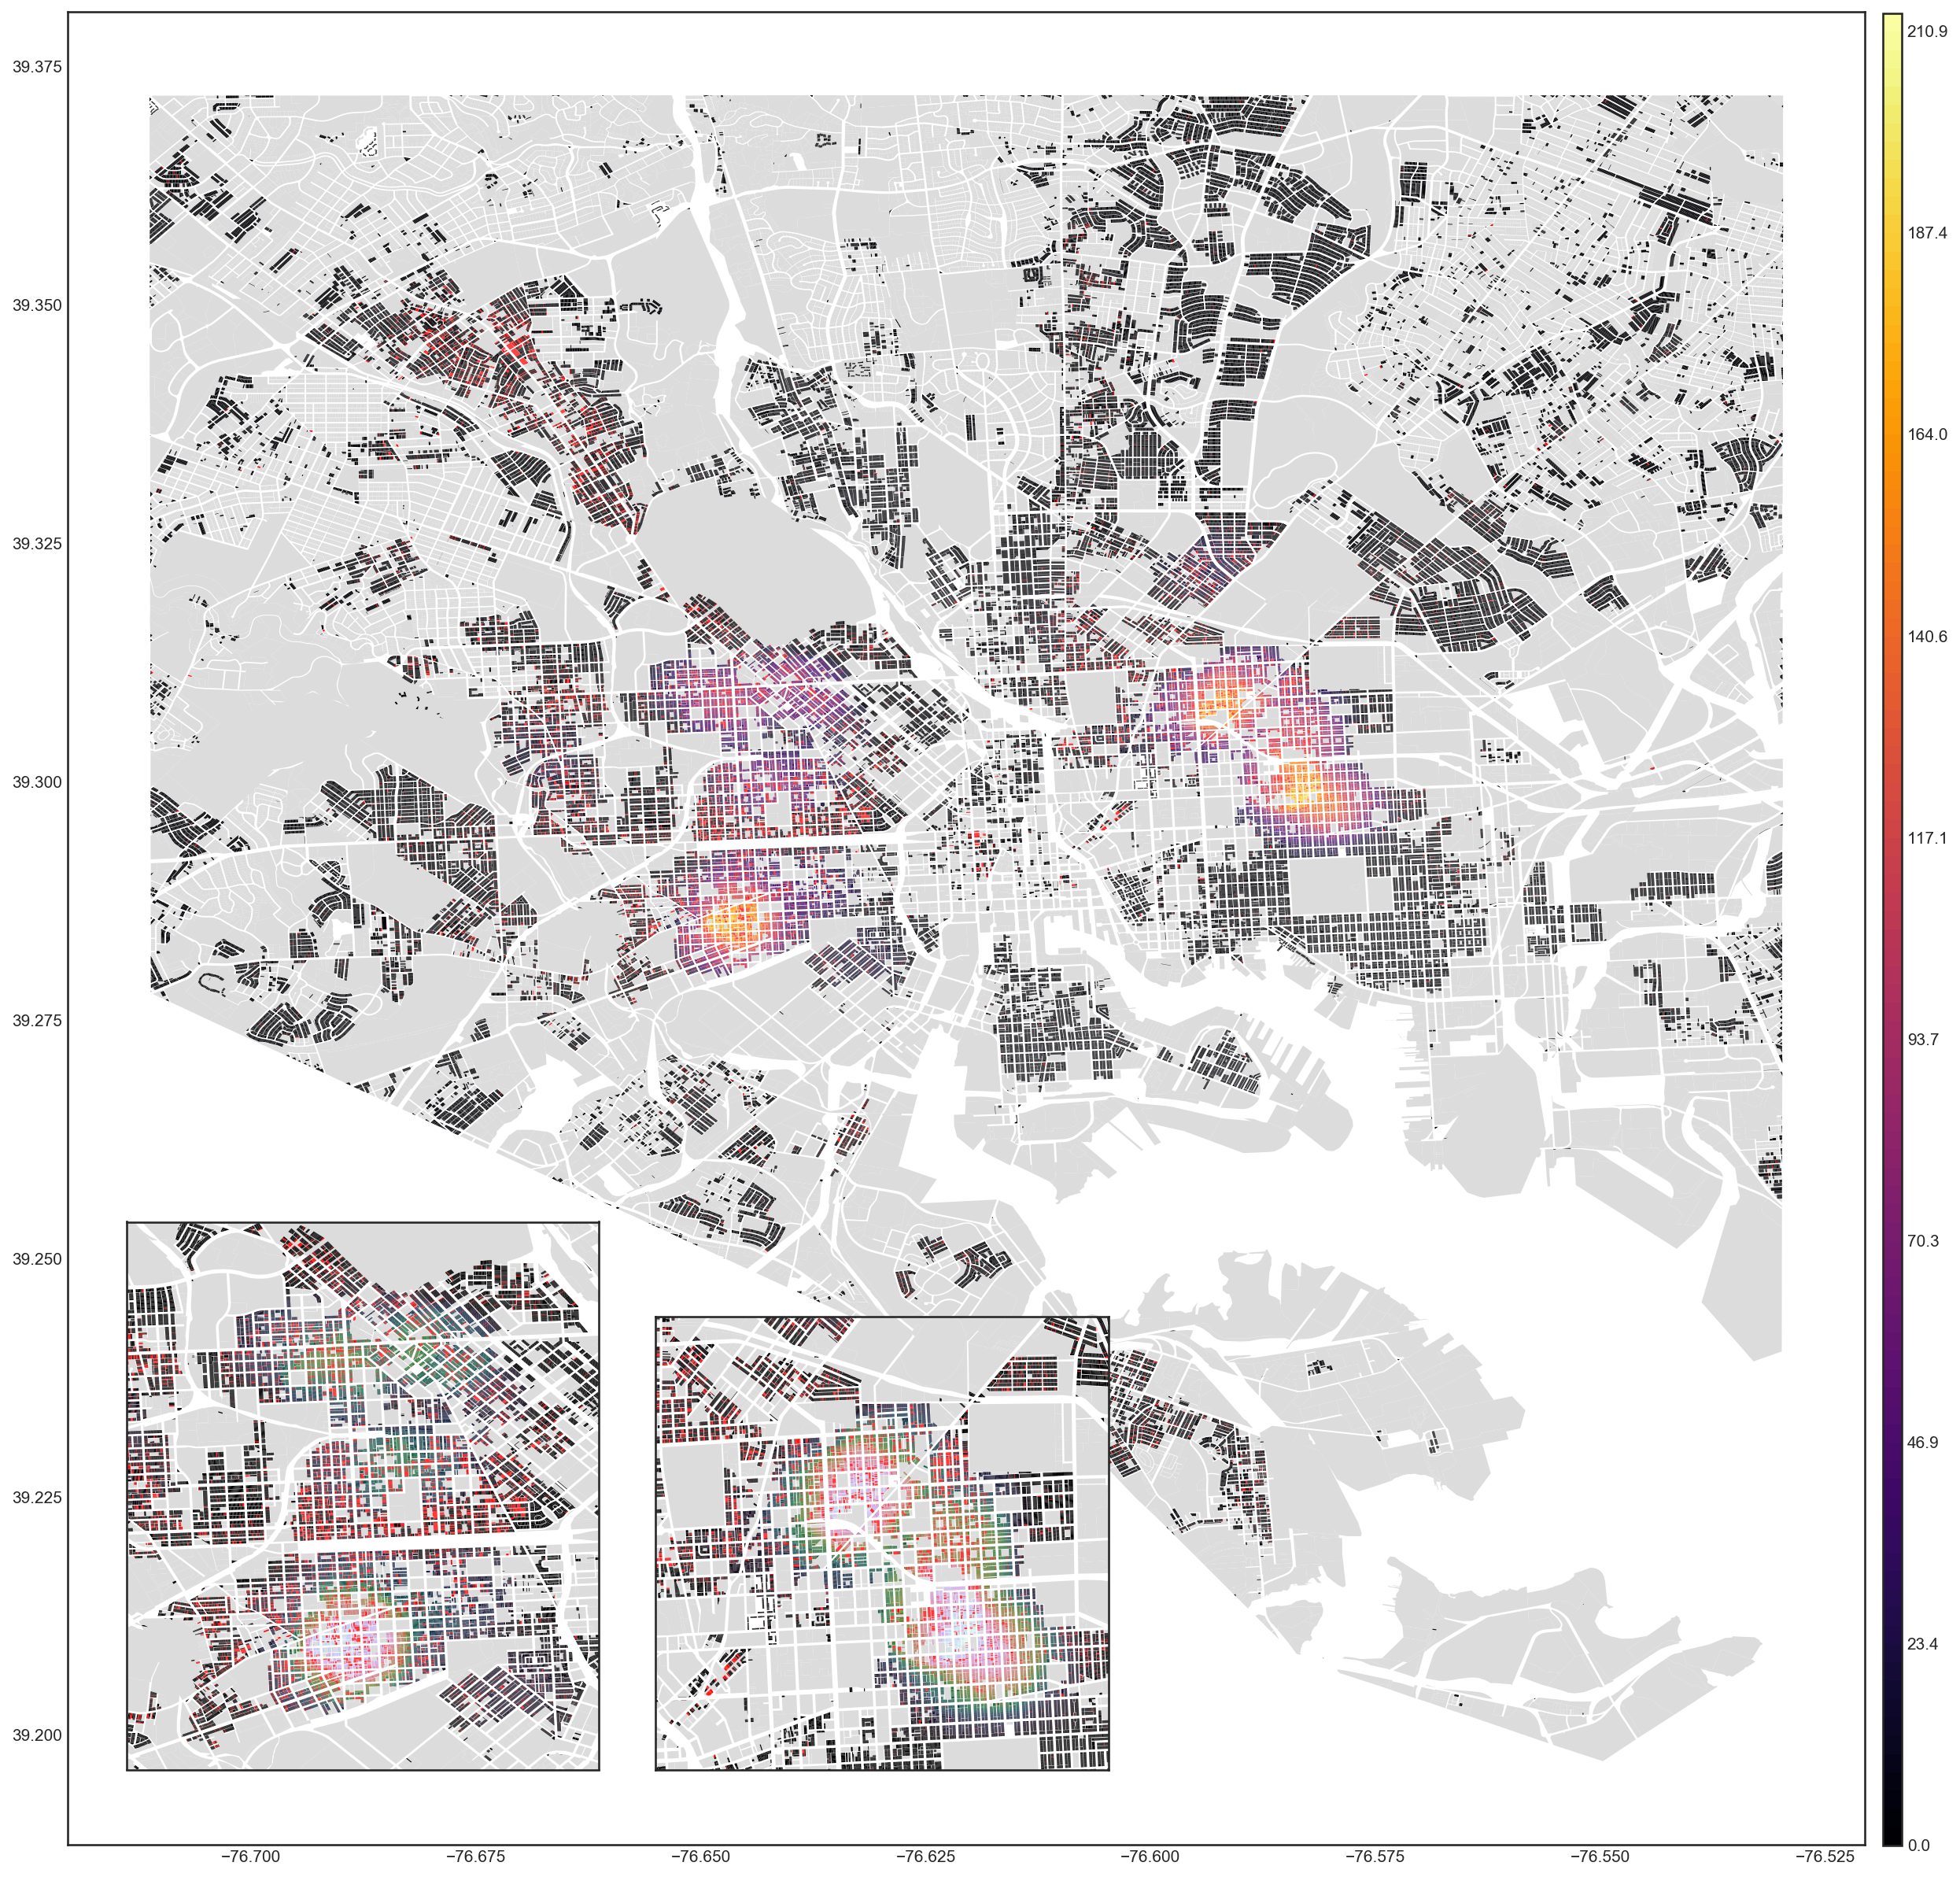

In [79]:
#fig = plt.figure(1, figsize=(16,16), dpi=150)
#ax = fig.add_subplot(111)
Area_plot("model-d400-p0" ,1, 20000000)